In [29]:
import numpy as np
import matplotlib.pyplot as plt
import gmsh
import os
import meshio

from units import mm, cm, m, kgf, N, tf, kN, MPa
from fem import Node, Material, Membrane, CST

In [30]:
L = 3*m  # Length of the beam
H = 30*cm  # Height of the beam
B = 30*cm  # Width of the beam
fc=28*MPa  # Concrete compressive strength
E=4700*(fc)**0.5  # Concrete modulus of elasticity
nu=0.2  # Concrete Poisson's ratio
pp= 2.4*(kgf/m**3)  *(B*H*L) # Concrete in tonf
print("Concrete density: ", pp, "tonf")
delta_a = 10*kgf*L/(E*B*H)  # Load per unit area

Concrete density:  6.354936 tonf


In [31]:
# General model parameters
def create_mesh(lc):
    output_path=os.path.join(os.path.expanduser("~"), "Documents", "FEM", "Ayudantia", "mesh")  # Path to save the mesh file
    mesh_name='beam'  # Name of the mesh file
    output_file=os.path.join(output_path, mesh_name + '.msh')  # Full path to the mesh file
    if not os.path.exists(output_path):
        os.makedirs(output_path)  # Create the output directory if it doesn't exist
    # Create a new GMSH model
    gmsh.initialize()
    gmsh.model.add("Beam")

    # Create the geometry of the beam
    # Create the corner points of the beam
    p1 = gmsh.model.geo.addPoint(0, 0, 0, lc)
    p2 = gmsh.model.geo.addPoint(L, 0, 0, lc)
    p3 = gmsh.model.geo.addPoint(L, H, 0, lc)
    p4 = gmsh.model.geo.addPoint(0, H, 0, lc)

    # Define the lines
    l1 = gmsh.model.geo.addLine(p1, p2)
    l2 = gmsh.model.geo.addLine(p2, p3)
    l3 = gmsh.model.geo.addLine(p3, p4)
    l4 = gmsh.model.geo.addLine(p4, p1)

    # Define the surface
    c1 = gmsh.model.geo.addCurveLoop([l1, l2, l3, l4]) # Create first a curve
    s1 = gmsh.model.geo.addPlaneSurface([c1]) # Create a surface from the curve

    # Synchronize the model to create the geometry
    gmsh.model.geo.synchronize()
    # Create mesh fine control and refinement
    # Create transfinite mesh for the surface
    gmsh.model.addPhysicalGroup(2, [s1], 201)  # Surface of the beam
    gmsh.model.setPhysicalName(2, 201, "Beam")  # Set the name of the physical group

    gmsh.model.addPhysicalGroup(1, [l4], 101)  # Left edge of the beam
    gmsh.model.setPhysicalName(1, 101, "Support")  # Set the name of the physical group

    gmsh.model.addPhysicalGroup(0, [p3], 1)  # Punto en el borde derecho de la viga
    gmsh.model.setPhysicalName(0, 1, "Load")  # Nombre del grupo físico para la carga

# Grupo físico para la línea l3 (borde superior) con carga distribuida
    gmsh.model.addPhysicalGroup(1, [l3], 103)  # Línea superior de la viga (carga distribuida)
    gmsh.model.setPhysicalName(1, 103, "Deadload")  # Nombre del grupo físico para la carga distribuida
    
    # Grupo físico para la línea l2 (borde derecho, si hay carga axial)
    gmsh.model.addPhysicalGroup(1, [l2], 104)  # Línea derecha de la viga (carga axial)
    gmsh.model.setPhysicalName(1, 104, "AxialLoad") 


    # Synchronize the model to create the geometry
    gmsh.model.geo.synchronize()


    gmsh.option.setNumber("Mesh.CharacteristicLengthMin", lc)
    gmsh.option.setNumber("Mesh.CharacteristicLengthMax", lc)


    gmsh.model.geo.synchronize()
    gmsh.model.mesh.generate(2)  # 2D mesh
    gmsh.fltk.run()

    gmsh.write(output_file)  # Save the mesh to a file

    return output_file



FEM Model

In [32]:
def analyze_mesh(output_file, caso):

    
    concrete=Material.Material(
        name='fc28',
        E=E,
        nu=0.2,
        rho=2.4*tf/m**3,
    )

    s1=Membrane.Membrane(
        name='s1',
        material=concrete,
        thickness=B,
    )

    mesh=meshio.read(output_file)  # Read the mesh file

    nodes = np.array([
        Node.Node(
            name=i + 1,  # ← empieza en 1 si usas tags Gmsh
            coordenadas=point[0:2]
        )
        for i, point in enumerate(mesh.points)
    ], dtype=object)  # ← necesario para arrays de objetos personalizados

    elements = []

    triangles = mesh.cells_dict['triangle']  # nodos por cada triángulo

    for i, node_list in enumerate(triangles):
        nodes_objects=nodes[node_list]
        elem = CST.CST(
            element_tag= i,
            node_list= nodes_objects,
            section= s1
        )
        elements.append(elem)
        
    # Convertir la lista a un array de objetos
    elements = np.array(elements, dtype=object)

    # We create some wrapper functions to access and replace matrix coefficients using row and column indices

    def matrix_extract(matrix: np.ndarray, row_indices: np.ndarray, col_indices: np.ndarray) -> np.ndarray:
        """
        Extracts submatrix values from a given matrix using specified row and column indices.

        Args:
            matrix (np.ndarray): The original matrix.
            row_indices (np.ndarray): Indices of the rows to extract.
            col_indices (np.ndarray): Indices of the columns to extract.

        Returns:
            np.ndarray: The extracted submatrix.
        """
        return matrix[np.ix_(row_indices, col_indices)]

    def matrix_replace(matrix: np.ndarray, matrix_add: np.ndarray, row_indices: np.ndarray, col_indices: np.ndarray) -> np.ndarray:
        """
        Adds a given submatrix to specific positions in a target matrix.

        Args:
            matrix (np.ndarray): The target matrix.
            matrix_add (np.ndarray): The submatrix to be added.
            row_indices (np.ndarray): Indices of the rows where addition should occur.
            col_indices (np.ndarray): Indices of the columns where addition should occur.

        Returns:
            np.ndarray: A new matrix with the submatrix added to the specified indices.
        """
        # Create a copy to avoid modifying the original matrix
        updated_matrix = matrix.copy()
        
        # Use np.ix_ for better readability and performance
        updated_matrix[np.ix_(row_indices, col_indices)] += matrix_add
        
        return updated_matrix


    def get_nodes_in_group(mesh, group_name: str, nodes_array: np.ndarray):
        """
        Devuelve los objetos Node correspondientes al grupo físico indicado.

        Args:
            mesh (meshio.Mesh): Malla cargada con meshio.read(...)
            group_name (str): Nombre del grupo físico (ej. 'Support', 'Load', 'Beam')
            nodes_array (np.ndarray): Arreglo de objetos Node indexado como Gmsh (i+1)

        Returns:
            np.ndarray: arreglo de objetos Node pertenecientes al grupo
        """
        if group_name not in mesh.field_data:
            raise ValueError(f"Grupo físico '{group_name}' no encontrado en la malla")

        group_id, dim = mesh.field_data[group_name]

        # Mapear la dimensión Gmsh a tipo de celda
        dim_to_cell = {0: 'vertex', 1: 'line', 2: 'triangle'}
        if dim not in dim_to_cell:
            raise NotImplementedError(f"No se soporta la dimensión {dim} por ahora")

        cell_type = dim_to_cell[dim]

        if cell_type not in mesh.cells_dict:
            raise ValueError(f"No se encontró '{cell_type}' en mesh.cells_dict")

        elements = mesh.cells_dict[cell_type]
        phys_ids = mesh.cell_data_dict["gmsh:physical"][cell_type]

        # Extraer nodos únicos del grupo físico
        node_ids = [n for e, g in zip(elements, phys_ids) if g == group_id for n in e]
        node_ids = np.unique(node_ids)  # Gmsh → Python indexing

        return nodes_array[node_ids]


    mesh.field_data
    mesh.cells_dict
    mesh.cell_data_dict
    

    support_nodes = get_nodes_in_group(mesh, 'Support', nodes)
    #---------------------------------------------------------------------------------
    dead_load_nodes = get_nodes_in_group(mesh, 'Deadload', nodes) ## Carga muerta
    total_dead_nodes = len(dead_load_nodes)
    qd= pp/total_dead_nodes
    #---------------------------------------------------------------------------------
    axial_load_nodes = get_nodes_in_group(mesh, 'AxialLoad', nodes) ## Carga axial
    number_axial_load_nodes = len(axial_load_nodes)
    
    qa=10*kgf/number_axial_load_nodes
    
    #---------------------------------------------------------------------------------

    

    for node in support_nodes:
        node.set_restrain(['r', 'r'])

    load_nodes = get_nodes_in_group(mesh, 'Load', nodes)
    if caso == 0:
        for node in load_nodes:
            node.set_nodalLoad([0,-1*tf])
    if caso == 1:
        for node in dead_load_nodes:
            node.set_nodalLoad([0, -qd])

    if caso == 2:

        for node in dead_load_nodes:
            node.set_nodalLoad([-qa,0])
    

    # We create a general purpose code to ensamble the global stiffness matrix using the element stiffness matrices and its indices

    nodeList=nodes
    elementList=elements

    # Get the number of nodes and elements
    nNodes=len(nodeList)
    nElements=len(elementList)

    # Set the global parameters
    globalParameters={'nDoF': 2}

    # Get the number of nodes, the number of nodes and the number of degrees of freedom per node define the size of the stiffness matrix
    system_nDof = globalParameters['nDoF']*nNodes


    # Create the global stiffness matrix filled with zeros
    Kg=np.zeros((system_nDof,system_nDof))

    # Assemble the global stiffness matrix
    for i,element in enumerate(elementList):
        Kg=matrix_replace(Kg,element.kg,element.idx,element.idx)

    # We assamble the global force vector for the joint loads



    Fj=np.zeros(system_nDof)

    # Create load mapping
    for i,node in enumerate(nodeList):
        Fj[node.idx]=node.nodalLoad


    # We create an index vector with the free and restrained degrees of freedom

    nodeIndex=np.full(system_nDof,'',dtype=str)

    for i,node in enumerate(nodeList):
        nodeIndex[node.idx]=node.restrain

    # Get the indices where the restrains are free and restrained


    freeIndices=np.where(nodeIndex=='f')[0]
    restrainedIndices=np.where(nodeIndex=='r')[0]



    # Solution procedure
    # We partition the global stiffness matrix into Kff, Kfr, Krf and Krr

    Kff=matrix_extract(Kg,freeIndices,freeIndices)
    Kfr=matrix_extract(Kg,freeIndices,restrainedIndices)
    Krf=matrix_extract(Kg,restrainedIndices,freeIndices)
    Krr=matrix_extract(Kg,restrainedIndices,restrainedIndices)

    # We partition the global force vector into Ff and Fr
    Ff=Fj[freeIndices]
    Fr=Fj[restrainedIndices]

    # We solve the system of equations
    # uf = Kff^-1 * (Ff - Kfr * ur)
    uf=np.linalg.solve(Kff,Ff-Kfr@Fr)
    ur=np.zeros(len(restrainedIndices))

    u=np.zeros(system_nDof)
    u[freeIndices]=uf
    u[restrainedIndices]=ur

    # Fr = Krf * uf + Krr * ur
    Fr=Krf@uf+Krr@ur

    F_reactions=np.zeros(system_nDof)
    F_reactions[restrainedIndices]=Fr

    # The joint load vector is:
    F=Fj+F_reactions

    return u, F, Kg, Fj, F_reactions, nodes, elements


In [33]:
def plot_results(densidad, deformaciones, delta, caso, printear):
    
    plt.figure(figsize=(8, 5))
    plt.plot(densidad,deformaciones[caso],  'bo-', label='Datos')  # 'bo-' para puntos azules conectados
    plt.axhline(y=delta[i], color='r', linestyle='--', label=f'Delta teórico')

    # Etiquetas y título
    plt.xlabel('Tamaño de lc')
    plt.ylabel('Deformación (mm)')
    plt.title(printear[i])
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Ahora que tenemos todo con funciones, se puede correr un código iterativo, para ver si la deformación va convergiendo

In [34]:
q=pp/L  
I=B*H**3/12

delta_1=-q*L**4/(8*E*I)
delta_0 =-1*tf*L**3/(3*E*I)
delta_2= 10*kgf*L/(E*B*H)  # Load per unit area
densidad=[ 30]
deformaciones=[]
delta = [delta_0, delta_1, delta_2]
caso= [0,1,2]
printear=["Carga puntual", "Carga muerta", "Carga axial"]

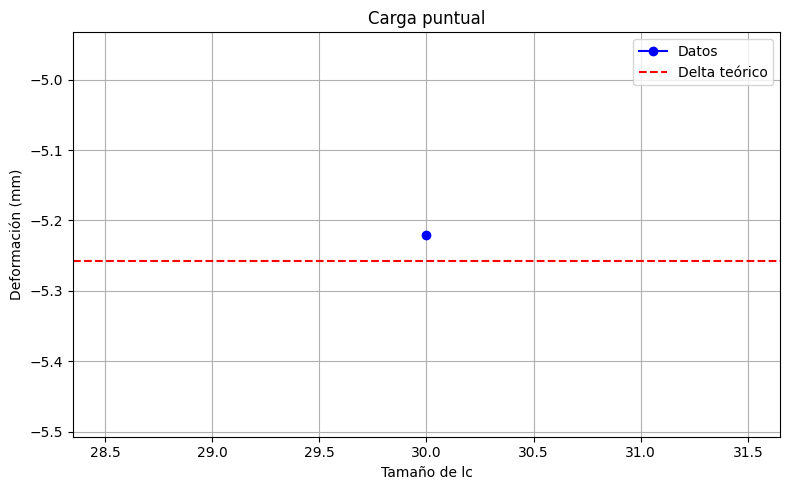

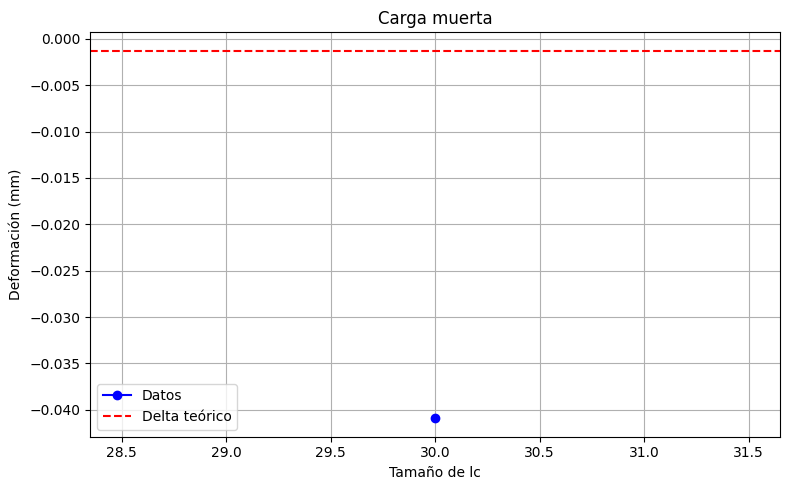

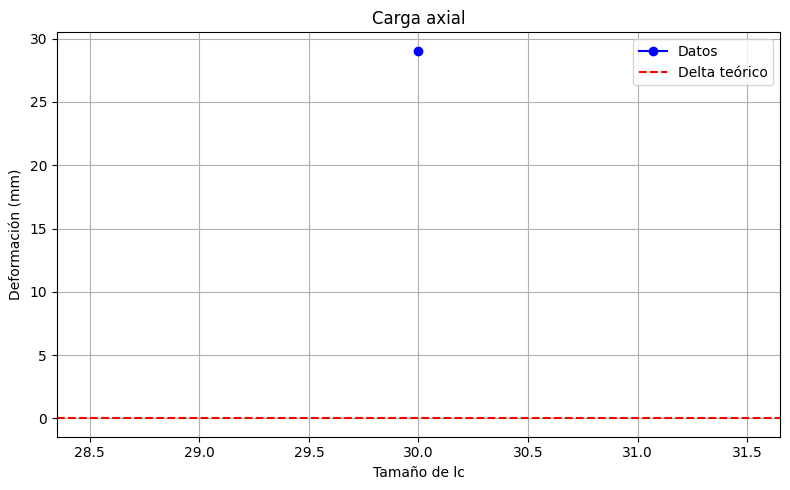

In [35]:
for i in caso:
    defor=[]
    for lc in densidad:
        output_file= create_mesh(lc)
        u, F, Kg, Fj, F_reactions, nodes, elements = analyze_mesh(output_file, i)
        defor.append(u[5])
    deformaciones.append(defor)
    plot_results(densidad, deformaciones,delta ,i, printear)


The manual solution typically assumes continuous material behavior, based on the exact equations of elasticity. It also considers a continuous variation of displacements and stresses throughout the domain, with boundary conditions defined and applied over a continuous geometry. Additionally, in many cases, the manual solution employs simplifications such as symmetries or ideal load distributions.

In contrast, the finite element solution discretizes the domain into individual elements, where displacement functions are approximated using piecewise interpolation. In the case of the CST element, a constant strain field is assumed within each element, which limits its ability to represent actual stress gradients. The accuracy of the FEM model also depends directly on the mesh size and quality, and numerical errors may be introduced due to approximations in interpolation, integration, and the application of boundary conditions.

In our case, the FEM solution underestimates the theoretical result. However, as observed in the graphs, the smaller the value of lc, the more accurate the solution becomes.